In [1]:
import nilearn
import nistats
from nistats.first_level_model import FirstLevelModel
import os
import pandas
import numpy as np
import nibabel as nib
import glob

from nilearn import plotting
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
from warnings import warn
from nistats.utils import _basestring
from nistats.contrasts import _fixed_effect_contrast
from patsy import DesignInfo

class FirstLevelModelSM(FirstLevelModel):
    
    def compute_contrast(self, contrast_def, stat_type=None,
                         output_type='z_score'):
        """
        SM version: Create contrast definition *per run separately* to ensure
        contrasts can be computed across runs/design matrices with varying numbers 
        of regressors (e.g., confounds)
        
        Generate different outputs corresponding to
        the contrasts provided e.g. z_map, t_map, effects and variance.
        In multi-session case, outputs the fixed effects map.
        Parameters
        ----------
        contrast_def : str or array of shape (n_col) or list of (string or
                       array of shape (n_col))
            where ``n_col`` is the number of columns of the design matrix,
            (one array per run). If only one array is provided when there
            are several runs, it will be assumed that the same contrast is
            desired for all runs. The string can be a formula compatible with
            the linear constraint of the Patsy library. Basically one can use
            the name of the conditions as they appear in the design matrix of
            the fitted model combined with operators /*+- and numbers.
            Please checks the patsy documentation for formula examples:
            http://patsy.readthedocs.io/en/latest/API-reference.html#patsy.DesignInfo.linear_constraint
        stat_type : {'t', 'F'}, optional
            type of the contrast
        output_type : str, optional
            Type of the output map. Can be 'z_score', 'stat', 'p_value',
            'effect_size' or 'effect_variance'
        Returns
        -------
        output : Nifti1Image
            The desired output image
        """
        if self.labels_ is None or self.results_ is None:
            raise ValueError('The model has not been fit yet')

        if isinstance(contrast_def, (np.ndarray, str)):
            con_vals = [contrast_def]
        elif isinstance(contrast_def, (list, tuple)):
            con_vals = contrast_def
        else:
            raise ValueError('contrast_def must be an array or str or list of'
                             ' (array or str)')
                
        n_runs = len(self.labels_)
        if len(con_vals) != n_runs:
            warn('One contrast given, assuming it for all %d runs' % n_runs)
            con_vals = con_vals * n_runs
        
        # Translate formulas to vectors with patsy
        for cidx, con in enumerate(con_vals):
            design_info = DesignInfo(self.design_matrices_[cidx].columns.tolist())
            if not isinstance(con, np.ndarray):
                con_vals[cidx] = design_info.linear_constraint(con).coefs


        if isinstance(output_type, _basestring):
            if output_type not in ['z_score', 'stat', 'p_value', 'effect_size',
                                   'effect_variance']:
                raise ValueError('output_type must be one of "z_score", "stat",'
                                 ' "p_value","effect_size" or "effect_variance"')
        else:
            raise ValueError('output_type must be one of "z_score", "stat",'
                             ' "p_value","effect_size" or "effect_variance"')

        contrast = _fixed_effect_contrast(self.labels_, self.results_,
                                          con_vals, stat_type)

        estimate_ = getattr(contrast, output_type)()
        # Prepare the returned images
        output = self.masker_.inverse_transform(estimate_)
        contrast_name = str(con_vals)
        output.header['descrip'] = (
            '%s of contrast %s' % (output_type, contrast_name))

        return output


In [3]:
# functions for combining echos

def combine_tedana(tes, data, combmode='t2s', mask=None, overwrite=True):
    """ Function based on tedana main workflow """
    from tedana import utils, model, io, decay, combine
    from scipy import stats
    import numpy as np
    import os
    
    # ensure tes are in appropriate format
    tes = [float(te) for te in tes]
    n_echos = len(tes)

    # coerce data to samples x echos x time array
    if isinstance(data, str):
        data = [data]

    catd, ref_img = io.load_data(data, n_echos=n_echos)
    n_samp, n_echos, n_vols = catd.shape
    
    mask, masksum = utils.make_adaptive_mask(catd, mask=mask, minimum=False, getsum=True)

    # check if the t2s-map is already created first
    base_name = data[0].replace('_echo-1', '').replace('desc-preproc-hp', 'desc-preproc-hp-%s').replace('.nii', '').replace('.gz', '')    
    
    if not os.path.exists(base_name %'t2sv' + '.nii.gz') or overwrite:
        t2s, s0, t2ss, s0s, t2sG, s0G = decay.fit_decay(catd, tes, mask, masksum)
        # set a hard cap for the T2* map
        # anything that is 10x higher than the 99.5 %ile will be reset to 99.5 %ile
        cap_t2s = stats.scoreatpercentile(t2s.flatten(), 99.5,
                                          interpolation_method='lower')
        t2s[t2s > cap_t2s * 10] = cap_t2s
        
        # save
        io.filewrite(t2s, base_name %'t2sv' + '.nii', ref_img, gzip=True)
        io.filewrite(s0, base_name %'s0v' + '.nii', ref_img, gzip=True)
        io.filewrite(t2ss, base_name %'t2ss' + '.nii', ref_img, gzip=True)
        io.filewrite(s0s, base_name %'s0vs' + '.nii', ref_img, gzip=True)
        io.filewrite(t2sG, base_name %'t2svG' + '.nii', ref_img, gzip=True)
        io.filewrite(s0G, base_name %'s0vG' + '.nii', ref_img, gzip=True)
        
    else:
        t2sG = utils.load_image(base_name %'t2svG' + '.nii.gz')
        t2s = utils.load_image(base_name %'t2sv' + '.nii.gz')
        
    # optimally combine data
    data_oc = combine.make_optcom(catd, tes, mask, t2s=t2sG, combmode=combmode)
    if combmode == 't2s':
        ext = 'optcomb'
    else:
        ext = 'PAID'
    print('Combined, writing results...')
    
    # make sure to set all nan-values/inf to 0
    data_oc[np.isinf(data_oc)] = 0
    data_oc[np.isnan(data_oc)] = 0
    io.filewrite(data_oc, base_name %ext + '.nii', ref_img, gzip=True)

In [4]:
import h5py
import pickle as pkl
from nilearn import plotting
import matplotlib.pyplot as plt
import nibabel as nib
import re
import pandas as pd

class FirstLevels(object):
    
    def __init__(self, subject_id, session, 
                 bids_root='data/deriv/fmriprep',
                 bold_space='MNI152NLin2009cAsym',
                 me_combination_method=None, smooth_fwhm=0, echo_n=None, highpassed_data=True):
        self.subject_id = subject_id
        self.session = session
        self.bids_root = bids_root
        self.t_r = 3.
        self.bold_space = bold_space
        self.me_tes = [0.00966, 0.02487, 0.04008]
        self.me_combination_method = me_combination_method  # optcomb, PAID, sm_t2s, sm_te-15
        self.highpassed_data = highpassed_data
        self.fwhm = smooth_fwhm
        self.echo_n = echo_n
        
        if self.me_combination_method is not None:
            if self.me_combination_method == 'optcomb':
                self.me_extension = 'optcomb'
            elif self.me_combination_method == 'PAID':
                self.me_extension = 'PAID'
            elif self.me_combination_method == 'sm_t2star':
                self.me_extension = 'sm_t2star'
            elif 'sm_te-' in self.me_combination_method:
                self.me_extension = self.me_combination_method
            
        self.anat_img = None
        
        self.session_func_dir = os.path.join(self.bids_root, 'sub-' + self.subject_id, 'ses-' + self.session, 'func')
        self.anat_dir = os.path.join(self.bids_root,  'sub-' + self.subject_id, 'anat')
        
        # set-up filenames
        if self.session == 'me':
            if self.echo_n is not None:
                model_fn = 'firstlevel_fwhm-{}_echo-{}.pkl'.format(self.fwhm, self.echo_n)
                contr_fn = 'contrasts_fwhm-{}_echo-{}.pkl'.format(self.fwhm, self.echo_n)
            else:
                model_fn = 'firstlevel_fwhm-{}_comb-{}.pkl'.format(self.fwhm, self.me_extension)
                contr_fn = 'contrasts_fwhm-{}_comb-{}.pkl'.format(self.fwhm, self.me_extension)
        else:
            model_fn = 'firstlevel_fwhm-{}.pkl'.format(self.fwhm)
            contr_fn = 'contrasts_fwhm-{}.pkl'.format(self.fwhm)

        self.models_dir = os.path.join(self.session_func_dir, '..', 'model')
        self.model_file = os.path.join(self.models_dir, model_fn)        
        self.contrasts_file = os.path.join(self.models_dir, contr_fn)
        
        if not os.path.exists(self.models_dir):
            os.makedirs(self.models_dir)
        
    def get_data_mask_confounds(self):
        fn_base = os.path.join(self.bids_root, 'sub-{}', 'ses-{}', 'func').format(self.subject_id, self.session)
        
        if self.highpassed_data:
            hp_appendix = '-hp'
        else:
            hp_appendix = ''
            
        if self.session == 'se':
            data = [os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix)) for x in [1,2,3]]
            mask = os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-1_space-{}_desc-brain_mask.nii.gz'.format(self.subject_id, self.session, self.bold_space))
            confounds = [os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x)) for x in [1,2,3]]
        else:
            mask = os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-1_echo-1_space-{}_desc-brain_mask.nii.gz'.format(self.subject_id, self.session, self.bold_space))
            if self.echo_n is not None:
                data = [os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_space-{}_desc-preproc{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.echo_n, self.bold_space, hp_appendix)) for x in [1,2,3]]
                confounds = [os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, self.echo_n)) for x in [1,2,3]]
            else:
                data = [os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}-{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix, self.me_extension)) for x in [1,2,3]]
                confounds = [os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, 1)) for x in [1,2,3]]
                # TO DO: re-generate confounds after echo combination!
#                 confounds = [os.path.join(fn_base, 'sub-{}_ses-{}_task-stop_run-{}_desc-confounds_regressors-{}.tsv'.format(self.subject_id, self.session, x, self.me_extension)) for x in [1,2,3]]
        print(data)
        return data, mask, confounds
    
    def get_onsets(self, run):
        
        fn = os.path.join(self.bids_root, 'sub-' + self.subject_id, 'ses-' + self.session, 
                          'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(self.subject_id, self.session, run))
        df = pandas.read_csv(fn, sep='\t')

        # Since many subjects do not have errors and we want the design matrices to be the same
        # across subjects, we only look at correct trials
        to_return = df[np.in1d(df.trial_type, ['go_trial', 'successful_stop', 'failed_stop'])].fillna(0.1)
        
        return to_return
    
    def load_confounds(self, path, fix_nans=True, 
                       include_confounds=('CSF', 'WhiteMatter', 'GlobalSignal', 
                                          'stdDVARS', 'non-stdDVARS', 'vx-wisestdDVARS', 
                                          'FramewiseDisplacement', 'tCompCor[\d+]', 'aCompCor[\d+]', 'Cosine[\d+]', 
                                          'NonSteadyStateOutlier[\d+]',
                                          'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'),
                       **kwargs):
        confs = pd.read_csv(path, sep='\t', **kwargs)
        
        for col in confs.columns.values:
            if pd.isnull(confs[col]).sum()>0:
                col_mean = confs[col].mean()
                confs[col] = confs[col].fillna(col_mean)
            
            # check if this column needs to be removed
            match = False
            for include in include_confounds:
                if re.match(include, col) is not None:
                    match = True
            
            if not match:
                del confs[col]
        print(confs.columns.values)
#             if 'NonSteadyStateOutlier' in col:
#                 del confs[col]
#             if remove_cosine:
#                 if 'Cosine' in col:
#                     del confs[col]
#             if remove_aCompCor:
#                 if 'aCompCor' in col:
#                     del confs[col]
#             if remove_aCompCor:
#                 if 'tCompCor' in col:
#                     del confs[col]
#        confs = confs.fillna(0)
#         if not 'NonSteadyStateOutlier00' in confs.columns:
#             confs['NonSteadyStateOutlier00'] = 0.
        return confs
    
    def combine_echos(self, mask=None):

        print('Echos not yet combined, doing so now using method %s' %self.me_combination_method)
        
        if self.me_combination_method == 'optcomb':
            for run in [1,2,3]:
                paths = [os.path.join(self.bids_root, 'sub-{}'.format(self.subject_id), 'ses-me/func', 
                                      'sub-{}_ses-me_task-stop_run-{}_echo-{}_space-{}_desc-preproc-hp_bold.nii.gz'.format(self.subject_id, run, x, self.bold_space)) for x in [1,2,3]]
                combine_tedana(self.me_tes, paths, combmode='t2s', mask=mask)
        
        elif self.me_combination_method == 'PAID':
            for run in [1,2,3]:
                paths = [os.path.join(self.bids_root, 'sub-{}'.format(self.subject_id), 'ses-me/func',
                                      'sub-{}_ses-me_task-stop_run-{}_echo-{}_space-{}_desc-preproc-hp_bold.nii.gz'.format(self.subject_id, run, x, self.bold_space)) for x in [1,2,3]]
                combine_tedana(self.me_tes, paths, combmode='ste', mask=mask)
        
#         elif 'sm_te-' in self.me_combination_method:
#             # get TE to interpolate
#             regex = re.compile('sm_te-(?P<te>\d+)')
#             te = regex.match(self.me_combination_method).groupdict()['te']
            
#             # get mean t2s-map, as well as volume-by-volume t2s-maps
#             for run in [1,2,3]:
#                 paths = [os.path.join(self.bids_root, 
#                                       'sub-' + self.subject_id, 
#                                       'ses-' + self.session, 
#                                       'func', 
#                                       'sub-%s_ses-%s_task-stop_run-'%(self.subject_id, self.session) + str(run) + '_echo-' + str(x) + '_bold_space-' + str(self.bold_space) + '_preproc%s.nii.gz' %('_hp' if self.highpassed_data else '')) for x in [1,2,3]]
                
#                 base_name = os.path.splitext(os.path.basename(paths[0]))[0].replace('.nii', '')  # splitext doesnt catch both nii and gz
#                 base_dir = os.path.dirname(os.path.abspath(paths[0]))
                
#                 for mean_time in [True, False]:
#                     if mean_time:
#                         name_ext_s0 = '_s0_mean.nii.gz'
#                         name_ext_t2s = '_t2s_mean.nii.gz'
#                     else:
#                         name_ext_s0 = '_s0.nii.gz'
#                         name_ext_t2s = '_t2s.nii.gz'
#                     fn_s0 = os.path.join(base_dir, base_name + name_ext_s0)
#                     fn_t2 = os.path.join(base_dir, base_name + name_ext_t2s)

#                     if not os.path.exists(fn_s0):
#                         find_t2(paths, tes=self.me_tes, mean_time=mean_time)
                        
#                     print('t2s maps created, interpolating...')
#                     interpolate_signal(s0_fn=paths[0].replace('.nii.gz', '_s0.nii.gz'),
#                                        t2s_fn=paths[0].replace('.nii.gz', '_t2s.nii.gz'),
#                                        t2s_map=paths[0].replace('.nii.gz', '_t2s_mean.nii.gz'),
#                                        t=te)
    
    def fit_first_level(self, smoothing_fwhm=0, n_jobs=10, overwrite=False, 
                        include_confounds=(), **kwargs):
        
        if os.path.exists(self.model_file) and not overwrite:
            print('Model already exists, loading from file...')
            with open(self.model_file, 'rb') as f:
                first_level_model = pkl.load(f)
        else:
            print('Fitting first level model...')
            data, mask, confounds = self.get_data_mask_confounds()
            
            
            if len(include_confounds)==0:
                confounds = None
            else:
                confounds = [self.load_confounds(x, include_confounds=include_confounds) for x in confounds]
            
            print(data[0])
            if not os.path.exists(data[0]):
                self.combine_echos(mask=mask)
            
            paradigm = [self.get_onsets(x) for x in [1,2,3]]
            
            first_level_model = FirstLevelModelSM(self.t_r, 
                                                  hrf_model='glover + derivative', 
                                                  smoothing_fwhm=smoothing_fwhm,
                                                  mask=mask,
                                                  n_jobs=n_jobs, **kwargs)
            print(data)
            first_level_model.fit(data, paradigm, confounds)
            
            with open(self.model_file, 'wb') as f:
                pkl.dump(first_level_model, f)
        
        self.first_level_model = first_level_model
        
        return self
    
    def compute_contrasts(self, contrasts, overwrite=False):
    
        if os.path.exists(self.contrasts_file) and not overwrite:
            print('Contrast file found, loading from file...')
            with open(self.contrasts_file, 'rb') as f:
                contr_dict = pkl.load(f)
        else:
            contr_dict = {}
            for contr in contrasts:
                print('Computing contrast %s...' %contr)
                contr_dict[contr] = self.first_level_model.compute_contrast(contr)
            
            with open(self.contrasts_file, 'wb') as f:
                pkl.dump(contr_dict, f)
            
        self.contrasts = contr_dict
        
    def load_anat_img(self):
        if self.anat_img is None:
            self.anat_img = nib.load(
                os.path.join(self.anat_dir, 'sub-%s_space-%s_desc-preproc_T1w.nii.gz' %(self.subject_id, self.bold_space)))
    
    def plot_contrasts(self, contrasts=None, **kwargs):
        
        # load bg image
        self.load_anat_img()

        if contrasts is None:
            # no contrasts provided, plot all
            f, ax = plt.subplots(len(self.contrasts), 1)
            for i, (contr_name, contr) in enumerate(self.contrasts.items()):
                plotting.plot_stat_map(contr, bg_img=self.anat_img, axes=ax[i], **kwargs)
            return f, ax
        else:
            # plot one or more, specified by contrasts argument
            for contr in contrasts:
                contr_plot = plotting.plot_stat_map(self.contrasts[contr], bg_img=self.anat_img, **kwargs)
            return contr_plot

<>:100: DeprecationWarning: invalid escape sequence \d


In [5]:
contrasts = ['failed_stop - go_trial',
             'successful_stop - go_trial',
             'failed_stop - successful_stop']

# movement parameters as only confounds
include_confounds=('framewise_displacement', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z')  

In [ ]:
n_jobs = 1
# loop the loop
for sub in range(1,19):
    sub_str = str(sub).zfill(2)

    for ses in ['me', 'se']:
        if ses=='me':
            if sub == 12:
                # sub 12, ses-me failed: pp could not hear audio. SE was fine though
                continue
            # combinations first
            for me_comb in ['PAID', 'optcomb']:
                print('Subject {}, session {}, {}... '.format(sub_str, ses, me_comb), end='')

                model = FirstLevels(sub_str, ses, 
                                    bids_root='./data/deriv/fmriprep/', 
                                    bold_space='MNI152NLin2009cAsym',
                                    me_combination_method=me_comb,
                                    highpassed_data=True)
                model.fit_first_level(n_jobs=n_jobs, include_confounds=include_confounds, smoothing_fwhm=0, 
                                      drift_model=None)
                model.compute_contrasts(contrasts)
            
            # Per echo second...
            for echo_n in [1,2,3]:
                print('Subject {}, session {}, echo {}... '.format(sub_str, ses, echo_n), end='')
                model = FirstLevels(sub_str, ses, 
                                    bids_root='./data/deriv/fmriprep/', 
                                    bold_space='MNI152NLin2009cAsym',
                                    me_combination_method=None,
                                    echo_n=echo_n,
                                    highpassed_data=True)
                model.fit_first_level(n_jobs=n_jobs, include_confounds=include_confounds, smoothing_fwhm=0, 
                                      drift_model=None)
                model.compute_contrasts(contrasts)
        else:
            print('Subject {}, session {}... '.format(sub_str, ses), end='')
            model = FirstLevels(sub_str, ses, 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym', highpassed_data=True)
            model.fit_first_level(n_jobs=n_jobs, include_confounds=include_confounds, smoothing_fwhm=0,
                                  drift_model=None)
            model.compute_contrasts(contrasts)

Subject 01, session me, PAID... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 01, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 01, session me, echo 1... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 01, session me, echo 2... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 01, session me, echo 3... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 01, session se... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 02, session me, PAID... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 02, session me, optcomb... Model already exists, loading from file...
Contrast file found, loading from file...
Subject 02, session me, echo 1... Model already exists, lo

/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Converting to None (no smoothing o

In [49]:
!ls ./data/deriv/fmriprep/sub

dataset_description.json  sub-04       sub-08	    sub-12	 sub-16
logs			  sub-04.html  sub-08.html  sub-12.html  sub-16.html
sub-01			  sub-05       sub-09	    sub-13	 sub-17
sub-01.html		  sub-05.html  sub-09.html  sub-13.html  sub-17.html
sub-02			  sub-06       sub-10	    sub-14	 sub-18
sub-02.html		  sub-06.html  sub-10.html  sub-14.html  sub-18.html
sub-03			  sub-07       sub-11	    sub-15
sub-03.html		  sub-07.html  sub-11.html  sub-15.html


## Check out some results!

Here, we:
1. Load the ROI atlas
2. Plot, for every ROI, a contour and the stat map

In [66]:
from nilearn.plotting import find_xyz_cut_coords
import matplotlib.pyplot as plt

roi_dict = {
    'STN_L': {'threshold': 0.3, 
              'color': 'white',
              'fn': './masks/final_masks_mni09a_1mm/STN_L_def-img.nii.gz'},
    'STN_R': {'threshold': 0.3, 
              'color': 'white',
              'fn': './masks/final_masks_mni09a_1mm/STN_R_def-img.nii.gz'},
    'STR_L': {'threshold': 0.3, 
              'color': 'blue',
              'fn': './masks/final_masks_mni09a_1mm/STR_L_def-img.nii.gz'},
    'STR_R': {'threshold': 0.3, 
              'color': 'blue',
              'fn': './masks/final_masks_mni09a_1mm/STR_R_def-img.nii.gz'},
    'PreSMA_L': {'threshold': 0.3,  #threshold is meaningless for preSMA
              'color': 'yellow',
              'fn': './masks/final_masks_mni09a_1mm/PreSMA_L_def-img.nii.gz'},
    'PreSMA_R': {'threshold': 0.3,  #threshold is meaningless for preSMA
                 'color': 'yellow',
                 'fn': './masks/final_masks_mni09a_1mm/PreSMA_R_def-img.nii.gz'},
    'ACC': {'threshold': 0.3, 
            'color': 'green',
            'fn': './masks/final_masks_mni09a_1mm/ACC_def-img.nii.gz'},
    'rIFG': {'threshold': 0.3, 
             'color': 'black',
             'fn': './masks/final_masks_mni09a_1mm/rIFG_def-img.nii.gz'},
    'M1': {'threshold': 0.3, 
           'color': 'pink',
           'fn': './masks/final_masks_mni09a_1mm/M1_def-img.nii.gz'},
    'GPi_L': {'threshold': 0.3, 
              'color': 'yellow',
              'fn': './masks/final_masks_mni09a_1mm/GPi_L_def-img.nii.gz'},
    'GPi_R': {'threshold': 0.3, 
              'color': 'yellow',
              'fn': './masks/final_masks_mni09a_1mm/GPi_R_def-img.nii.gz'},
    'GPe_L': {'threshold': 0.3, 
              'color': 'brown',
              'fn': './masks/final_masks_mni09a_1mm/GPe_L_def-img.nii.gz'},
    'GPe_R': {'threshold': 0.3, 
              'color': 'brown',
              'fn': './masks/final_masks_mni09a_1mm/GPe_R_def-img.nii.gz'},
}

def get_prop_limits(props, current_limits):
    extent = current_limits[1]-current_limits[0]
    x0 = current_limits[0] + extent*props[0]
    x1 = current_limits[0] + extent*props[1]
    return (x0, x1)

def add_contours(disp, roi, thr=0.3, linewidth=1, color='white', **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    
    map_img = nib.load(roi)
    data = map_img.get_data()
    # threshold manually
    
    
    thr = check_threshold(thr, data,
                          percentile_func=fast_abs_percentile,
                          name='threshold')
    
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    if data.max() > 1:
        thr = thr*100
    disp.add_contours(roi, levels=[thr], linewidth=linewidth, colors=[color], **kwargs)

# mask_dir = './masks/final_masks_mni09a_1mm'
# roi_dict = {
#     'STR_L': mask_dir + '/STR_L_def-img.nii.gz',
#     'STR_R': mask_dir + '/STR_R_def-img.nii.gz',
#     'STN_L': mask_dir + '/STN_L_def-img.nii.gz',
#     'STN_R': mask_dir + '/STN_R_def-img.nii.gz',
#     'PreSMA_L': mask_dir + '/PreSMA_L_def-img.nii.gz',
#     'PreSMA_R': mask_dir + '/PreSMA_R_def-img.nii.gz',
#     'rIFG': mask_dir + '/rIFG_def-img.nii.gz',
#     'ACC': mask_dir + '/ACC_def-img.nii.gz',
#     'M1': mask_dir + '/M1_def-img.nii.gz',
# }

from scipy.stats import norm
p005_unc = norm.isf(0.005)

def plot_firstlevel_results(model, roi_map, z_threshold=p005_unc,
                            roi_to_plot=('PreSMA', 'M1', 'ACC', 'rIFG', 'STR',
                                         'GPe', 'GPi', 'STN'), 
                            contrasts=('failed_stop - go_trial',
                                       'successful_stop - go_trial',
                                       'failed_stop - successful_stop')):
    model.load_anat_img()  ## make sure this is available
    f, axes = plt.subplots(len(roi_to_plot), len(contrasts))

    for row_n, roi in enumerate(roi_to_plot):
        # get cut coordinates based on 1 hemisphere (if applicable)
        if roi in ['STR', 'STN', 'PreSMA', 'GPe', 'GPi']:
            roi_map = roi_dict[roi + '_L']
        else:
            roi_map = roi_dict[roi]
        cut_coords = find_xyz_cut_coords(roi_map['fn'])[2:3]

        # loop over contrasts for columns
        for col_n, contr in enumerate(contrasts):
            ax = axes[row_n, col_n]
            disp = plotting.plot_stat_map(model.contrasts[contr], bg_img=model.anat_img, 
                                          threshold=z_threshold, cut_coords=cut_coords,
                                          display_mode='z', axes=ax)

            # just plot *all* contours, always
            for roi_, roi_map in roi_dict.items():
                add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'])

            # set new xlimits if necessary (ie zoom for STN view)
            if 'STN' in roi:
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([.25, .75], cur_xlim)
                new_ylim = get_prop_limits([.40, .90], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])

    # add labels
    for ax, nm in zip(axes[0], contrasts):
        ax.set_title(nm)
    for ax, row in zip(axes[:,0], roi_to_plot):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 0, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points', rotation=90,
                    size='large', ha='right', va='center')

    f.set_size_inches(len(contrasts)*4, len(roi_to_plot)*4)
    
    return f

01
Model already exists, loading from file...
Contrast file found, loading from file...


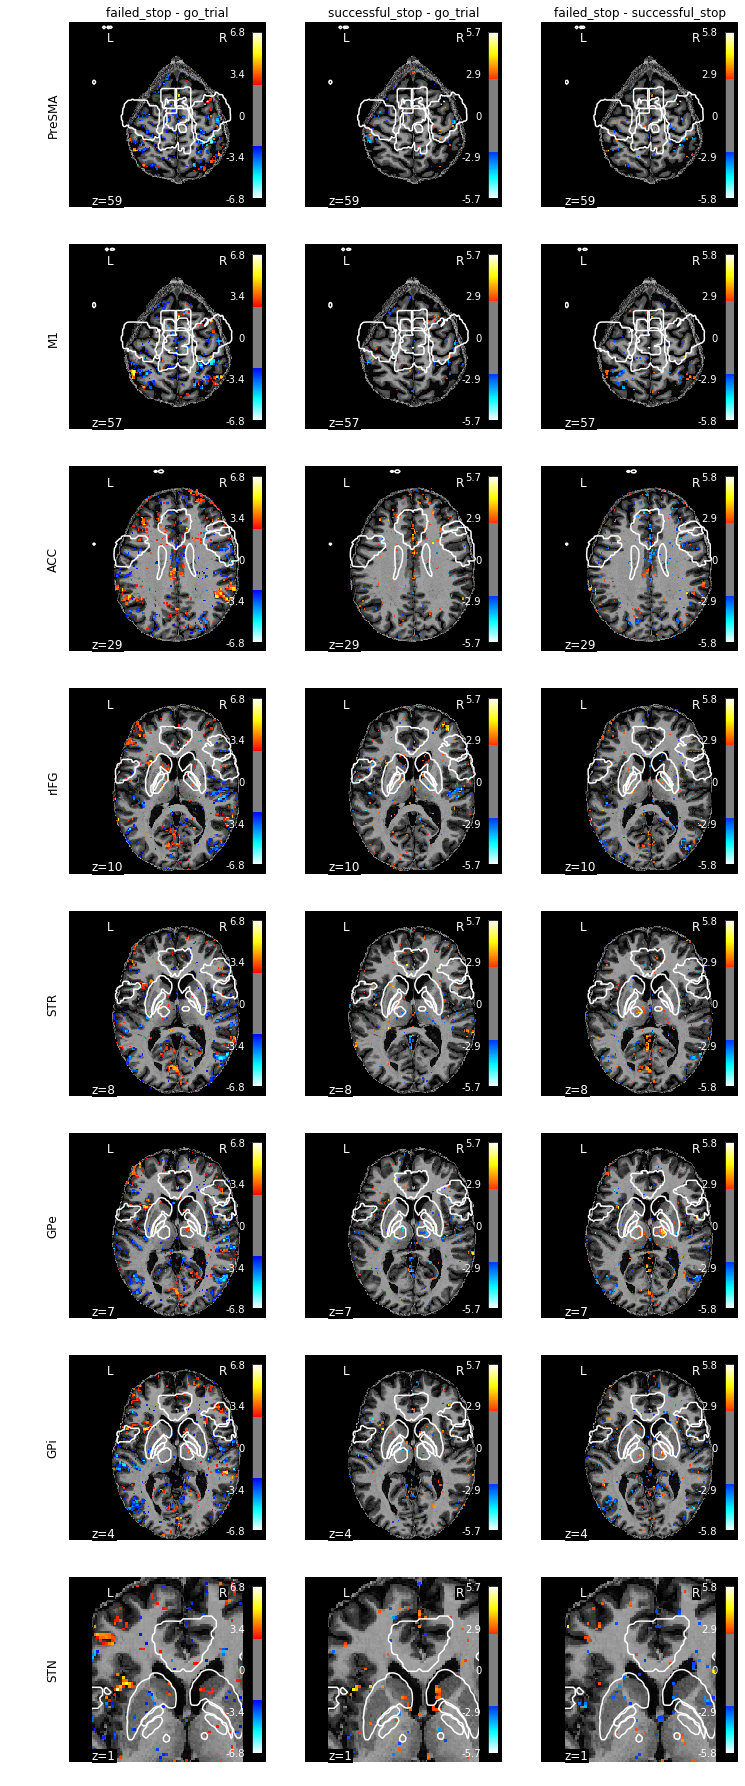

In [19]:
## plot all
contrasts = ['failed_stop - go_trial',
             'successful_stop - go_trial',
             'failed_stop - successful_stop']

include_confounds=('CSF', 'WhiteMatter', 'GlobalSignal', 
                   'stdDVARS', 'non-stdDVARS', 'vx-wisestdDVARS', 
                   'FramewiseDisplacement', 'tCompCor[\d+]', 'aCompCor[\d+]',
                   'NonSteadyStateOutlier[\d+]',
                   'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ')

for sub in range(1, 2):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    ses='se'
    model = FirstLevels(sub_str, ses, 
                bids_root='./data/deriv/fmriprep/', 
                bold_space='mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm')
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    model.compute_contrasts(contrasts)

    # plot
#    save_fn = './data/deriv/fmriprep/sub-%s/ses-%s/model/sub-%s_ses-%s_rois.pdf' %(sub_str, ses, sub_str, ses)
    f = plot_firstlevel_results(model, roi_dict)
#    f.savefig(save_fn, bbox_type='tight')
f.show()

In [ ]:
## plot all
contrasts = ['failed_stop - go_trial',
             'successful_stop - go_trial',
             'failed_stop - successful_stop']

include_confounds=('CSF', 'WhiteMatter', 'GlobalSignal', 
                   'stdDVARS', 'non-stdDVARS', 'vx-wisestdDVARS', 
                   'FramewiseDisplacement', 'tCompCor[\d+]', 'aCompCor[\d+]',
                   'NonSteadyStateOutlier[\d+]',
                   'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ')

for sub in range(8,10):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    for ses in ['se', 'me']:
        print(ses)
        if ses=='me':
            for me_comb in ['optcomb', 'PAID']:
                model = FirstLevels(sub_str, ses, 
                            bids_root='./data/deriv/fmriprep/', 
                            bold_space='mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm',
                            me_combination_method=me_comb)
                model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
                model.compute_contrasts(contrasts)
                
                # plot
                save_fn = './data/deriv/fmriprep/sub-%s/ses-%s/model/sub-%s_ses-%s_method-%s_rois.pdf' %(sub_str, ses, sub_str, ses, me_comb)
                f = plot_firstlevel_results(model, roi_dict)
                f.savefig(save_fn, bbox_type='tight')
        else:
            model = FirstLevels(sub_str, ses, 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm')
            model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
            model.compute_contrasts(contrasts)
            
            # plot
            save_fn = './data/deriv/fmriprep/sub-%s/ses-%s/model/sub-%s_ses-%s_rois.pdf' %(sub_str, ses, sub_str, ses)
            f = plot_firstlevel_results(model, roi_dict)
            f.savefig(save_fn, bbox_type='tight')


### Second level model
1. Single echo

In [21]:
ses = 'se'
me_comb = 'optcomb'  # or PAID
first_level_models_se = []
first_level_models_me = []

for sub in [1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,18]:
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    # load se
    model = FirstLevels(sub_str, 'se', 
                bids_root='./data/deriv/fmriprep/', 
                bold_space='mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm',
                me_combination_method=me_comb, highpassed_data=True)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    model.compute_contrasts(contrasts)
    first_level_models_se.append(model.first_level_model)
    
    # load me
    model = FirstLevels(sub_str, 'me', 
                bids_root='./data/deriv/fmriprep/', 
                bold_space='mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm',
                me_combination_method=me_comb, highpassed_data=True)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    model.compute_contrasts(contrasts)
    first_level_models_me.append(model.first_level_model)

01
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
02
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
03
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
04
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
05
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
06
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Cont

In [76]:
from nistats.second_level_model import SecondLevelModel

# SE
second_level_model_se = SecondLevelModel(smoothing_fwhm=0)
second_level_model_se = second_level_model_se.fit(first_level_models_se)
zmaps_se = {contrasts[0]: second_level_model_se.compute_contrast(first_level_contrast=contrasts[0]),
            contrasts[1]: second_level_model_se.compute_contrast(first_level_contrast=contrasts[1]),
            contrasts[2]: second_level_model_se.compute_contrast(first_level_contrast=contrasts[2])}

# ME
second_level_model_me = SecondLevelModel(smoothing_fwhm=0)
second_level_model_me = second_level_model_me.fit(first_level_models_me)
zmaps_me = {contrasts[0]: second_level_model_me.compute_contrast(first_level_contrast=contrasts[0]),
            contrasts[1]: second_level_model_me.compute_contrast(first_level_contrast=contrasts[1]),
            contrasts[2]: second_level_model_me.compute_contrast(first_level_contrast=contrasts[2])}

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: One contrast given, assuming it for all 3 runs
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/image/image.py:192: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Converting to None (no smoothing option)
  .format(fwhm))


In [ ]:
# def make_conjunction_mask(roi, brain_mask):
#     from nilearn.masking import NiftiMasker
#     NiftiMasker()

In [19]:
from scipy.stats import norm
p005_unc = norm.isf(0.005)

def plot_secondlevel_results(zmaps, roi_map, bg_img=None, z_threshold=p005_unc,
                             brain_mask='../Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                             roi_to_plot=('PreSMA', 'M1', 'ACC', 'rIFG', 'STR', 'GPe', 'GPi', 'STN'),
                             cut_coords=[None, None, None, None, None, None, None, None],
                             contrasts=('failed_stop - go_trial',
                                        'successful_stop - go_trial',
                                        'failed_stop - successful_stop'),
                            **kwargs):
    f, axes = plt.subplots(len(roi_to_plot), len(contrasts))

    for row_n, roi in enumerate(roi_to_plot):
        # get cut coordinates based on 1 hemisphere (if applicable)
        if roi in ['STR', 'STN', 'PreSMA', 'GPe', 'GPi']:
            roi_map = roi_dict[roi + '_L']
        else:
            roi_map = roi_dict[roi]
#        roi_map = make_conjunction_mask(roi_map['fn'], brain_mask)
        if roi == 'rIFG':
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[0:1]
            else:
                this_cut_coords = cut_coords[row_n]
            display_mode='x'
            plot_rois = ['rIFG', 'M1', 'PreSMA_R']
        else:
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[2:3]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='z'
            plot_rois = ['STR_L', 'GPe_L', 'GPi_L', 'STN_L',
                         'STR_R', 'GPe_R', 'GPi_R', 'STN_R']
        
        print(this_cut_coords)
        print(display_mode)
        # loop over contrasts for columns
        for col_n, (contr_name, zmap) in enumerate(zmaps.items()):
            if isinstance(z_threshold, list):
                this_threshold = z_threshold[col_n]
            else:
                this_threshold = z_threshold
            ax = axes[row_n, col_n]

            disp = plotting.plot_stat_map(zmap, bg_img=bg_img, 
                                          threshold=this_threshold, cut_coords=this_cut_coords,
                                          display_mode=display_mode, axes=ax, **kwargs)

            # just plot *all* contours, always
            for roi_ in plot_rois:
                roi_map = roi_dict[roi_]
#             for roi_, roi_map in roi_dict.items():
                add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

            # set new xlimits if necessary (ie zoom for STN view)
            if 'STN' in roi:
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([.25, .75], cur_xlim)
                new_ylim = get_prop_limits([.40, .90], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])

    # add labels
#     for ax, nm in zip(axes[0], zmaps.keys()):
#         ax.set_title(nm)
#     for ax, row in zip(axes[:,0], roi_to_plot):
#         ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 0, 0),
#                     xycoords=ax.yaxis.label, textcoords='offset points', rotation=90,
#                     size='large', ha='right', va='center')

    f.set_size_inches(len(contrasts)*4, len(roi_to_plot)*4)
    
    return f, axes

PreSMA_L
PreSMA_R
rIFG
M1


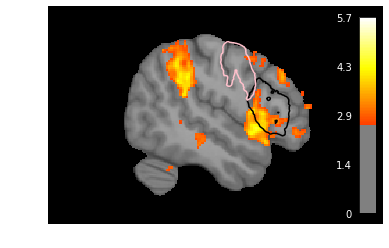

In [283]:
rois_to_plot = ('PreSMA_R', 'PreSMA_L', 'rIFG', 'M1')
f, axes = plt.subplots(1, 1)
cut_coords = [50]
disp = plotting.plot_stat_map(zmaps_se['failed_stop - go_trial'], axes=axes,
                              bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                              cut_coords=cut_coords, display_mode='x', threshold=thresholds_se[0], annotate=False)

for roi_, roi_map in roi_dict.items():
    if roi_ in rois_to_plot:
        print(roi_)
        add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

In [50]:
this_cut_coords = find_xyz_cut_coords(roi_dict['STN_R']['fn'])
this_cut_coords

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


[9.790039157578946, -13.085788944856162, -6.3322527043513475]

(-17.340740740740742, 37.318518518518516)

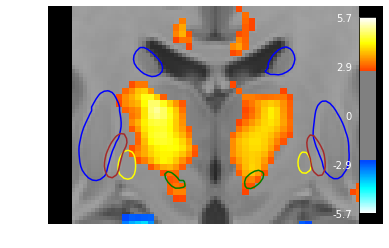

In [52]:
rois_to_plot = ('PreSMA_R', 'PreSMA_L', 'rIFG', 'M1', 'STN_L', 'STN_R', 'GPi_L', 'GPi_R', 'GPe_L', 'GPe_R', 'STR_L', 'STR_R')
f, axes = plt.subplots(1, 1)
cut_coords = [-13]
disp = plotting.plot_stat_map(zmaps_se['failed_stop - go_trial'], axes=axes,
                              bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                              cut_coords=cut_coords, display_mode='y', threshold=thresholds_se[0], annotate=False)

for roi_, roi_map in roi_dict.items():
    if roi_ in rois_to_plot:
        add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])
        
this_key = [x for x in disp.axes.keys()]
this_key = this_key[0]
cur_xlim = disp.axes[this_key].ax.get_xlim()
cur_ylim = disp.axes[this_key].ax.get_ylim()
new_xlim = get_prop_limits([.25, .75], cur_xlim)
new_ylim = get_prop_limits([.35, .70], cur_ylim)
disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])

In [17]:
# rois_to_plot = ('PreSMA_R', 'PreSMA_L', 'rIFG', 'M1')
# f, axes = plt.subplots(2, 1)
# cut_coords = [50]
# disp = plotting.plot_stat_map(zmaps_se['failed_stop - go_trial'], axes=axes[0],
#                               bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz',
#                               cut_coords=cut_coords, display_mode='x', threshold=thresholds_se[0], colorbar=False,
#                               annotate=False)

# for roi_, roi_map in roi_dict.items():
#     if roi_ in rois_to_plot:
#         print(roi_)
#         add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

# cut_coords = [55]
# disp = plotting.plot_stat_map(zmaps_se['failed_stop - go_trial'], axes=axes[1],
#                               bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz',
#                               cut_coords=cut_coords, display_mode='z', threshold=thresholds_se[0], colorbar=False,
#                               annotate=False)

# for roi_, roi_map in roi_dict.items():
#     if roi_ in rois_to_plot:
#         print(roi_)
#         add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])


# plt.tight_layout()
# plt.gcf().set_size_inches(4,10)

In [253]:
# from nighres.registration import apply_coordinate_mappings
# stat_map_upscaled = apply_coordinate_mappings(stat_map, './masks/registration/MNI09a_2_1p6mm_ants-invmap.nii.gz')


Apply coordinate mappings


/home/stevenm/miniconda3/lib/python3.7/site-packages/nighres/registration/apply_coordinate_mappings.py:87: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  hdr = img.get_header()
/home/stevenm/miniconda3/lib/python3.7/site-packages/nighres/registration/apply_coordinate_mappings.py:88: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  aff = img.get_affine()


In [15]:
# def upscale_zmaps(zmaps):
#     out = {}
#     for map_name, z_map in zmaps.items():
#         out[map_name] = apply_coordinate_mappings(z_map, './masks/registration/MNI09a_2_1p6mm_ants-invmap.nii.gz')['result']
        
#     return out

# zmaps_se_upscaled = upscale_zmaps(zmaps_se)

In [16]:
# def add_stat_map(stat_map, threshold, cut_coords, upscale=False, cmap='hot', ax=None):
    
#     if upscale:
#         stat_map = apply_coordinate_mappings(stat_map, './masks/registration/MNI09a_2_1p6mm_ants-invmap.nii.gz', interpolation='nearest')
#         stat_map = stat_map['result']
    
#     stat_map = stat_map.get_data()
    
#     # threshold
#     stat_map[stat_map < threshold] = np.nan
#     if ax is None:
#         plt.imshow(stat_map[cut_coords[0],:,:].T, origin='lower', cmap=cmap)
#     else:
#         ax.imshow(stat_map[cut_coords[0],:,:].T, origin='lower', cmap=cmap)

In [9]:
# def plot_stat_map_roi(zmap, stat_threshold, cut_coords=[52,0,0], rois=('PreSMA_L', 'PreSMA_R'), mask_threshold=None,
#                       bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz', 
#                       ax=None, xlim=None, ylim=None):

#     if ax is None:
#         f, ax = plt.subplots(1, 1)
        
#     bg_hdr = nib.load(bg_img)
#     bg_img = bg_hdr.get_data()
#     if bg_img.ndim == 4:
#         bg_img = bg_img[:,:,:,0]
#     cut_coords_mni = cut_coords
#     cut_coords_matrix = np.round(apply_affine(pinv(bg_hdr.affine), cut_coords_mni)).astype(int)

#     # background
#     ax.imshow(bg_img[cut_coords_matrix[0],:,:].T, origin='lower', cmap='gist_gray')

#     # stat map
#     add_stat_map(zmap, stat_threshold, cut_coords_matrix, upscale=False, ax=ax)

#     # add contours
#     for mask in rois:
#         mask_data = nib.load('./masks/final_masks_mni09a_1mm/%s_def-img.nii.gz'%mask).get_data()[cut_coords_matrix[0],:,:].T
        
#         if mask_threshold is None:
#             ax.contour(mask_data)
#         else:
#             if mask_data.max() > 1 and mask_threshold <= 1:
#                 mask_threshold = mask_threshold * 100
#             ax.contour(mask_data, levels=[mask_threshold])

#     # set limits x, y
#     if xlim is not None:
#         ax.set_xlim(xlim[0], xlim[1])
#     if ylim is not None:
#         ax.set_ylim(ylim[0], ylim[1])
    
#     # turn off axes ticks & stuff
#     ax.axis('off')

# f, axes = plt.subplots(1,3)
# contrast_names = [x for x in zmaps_se_upscaled.keys()]
# plot_stat_map_roi(zmaps_se_upscaled[contrast_names[0]], thresholds_se[0], rois=['PreSMA_L', 'rIFG'],
#                   mask_threshold=0.3, xlim=(40, 190), ylim=(20, 140), ax=axes[0])
# plot_stat_map_roi(zmaps_se_upscaled[contrast_names[1]], thresholds_se[1], rois=['PreSMA_L', 'rIFG'],
#                   mask_threshold=0.3, xlim=(40, 190), ylim=(20, 140), ax=axes[1])
# plot_stat_map_roi(zmaps_se_upscaled[contrast_names[2]], thresholds_se[2], rois=['PreSMA_L', 'rIFG'],
#                   mask_threshold=0.3, xlim=(40, 190), ylim=(20, 140), ax=axes[2])

# f.tight_layout()
# f.subplots_adjust(wspace=0.00, hspace=0.0)
# f.set_size_inches(12,4)

In [10]:
# thresholds_se

In [11]:
# contrast_names[0]

In [12]:
# import nibabel as nib
# from nibabel.affines import apply_affine
# from numpy.linalg import pinv

# bg_hdr = nib.load('/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz')
# bg_img = bg_hdr.get_data()
# if bg_img.ndim == 4:
#     bg_img = bg_img[:,:,:,0]
# cut_coords_mni = [52,0,0]
# cut_coords_matrix = np.round(apply_affine(pinv(bg_hdr.affine), cut_coords_mni)).astype(int)

# # background
# plt.imshow(bg_img[cut_coords_matrix[0],:,:].T, origin='lower', cmap='gist_gray')

# # stat map
# add_stat_map(zmaps_se_upscaled['failed_stop - go_trial'], thresholds_se[0], cut_coords_matrix, upscale=False)

# # add contours
# for mask in ['rIFG', 'M1']:
#     mask_data = nib.load('./masks/final_masks_mni09a_1mm/%s_def-img.nii.gz'%mask).get_data()[cut_coords_matrix[0],:,:].T
#     plt.contour(mask_data, levels=[30])

# # set limits x, y
# plt.xlim(40, 190)
# plt.ylim(20, 140)

# #
# #plt.gcf().set_size_inches(10, 20)

In [13]:
# import nibabel as nib
# from nibabel.affines import apply_affine
# from numpy.linalg import pinv

# bg_hdr = nib.load('./masks/registration/MNI09a_2_1p6mm_ants-def.nii.gz')
# bg_img = bg_hdr.get_data()
# cut_coords_mni = [50,0,0]
# cut_coords_matrix = np.round(apply_affine(pinv(bg_hdr.affine), cut_coords_mni)).astype(int)

# # background
# plt.imshow(bg_img[cut_coords_matrix[0],:,:].T, origin='lower', cmap='gist_gray')

# # stat map
# #stat_map_upscaled = apply_coordinate_mappings(stat_map, './masks/registration/MNI09a_2_1p6mm_ants-invmap.nii.gz')
# stat_map = zmaps_se['failed_stop - go_trial'].get_data()
# # threshold
# stat_map[stat_map<thresholds_se[0]] = np.nan
# plt.imshow(stat_map[cut_coords_matrix[0],:,:].T, origin='lower')
# #plt.gcf().set_size_inches(10, 20)

In [14]:
# rois_to_plot = ('PreSMA_R', 'PreSMA_L', 'rIFG', 'M1')
# f, axes = plt.subplots(1, 1)
# cut_coords = [2]
# disp = plotting.plot_stat_map(zmaps_se['failed_stop - go_trial'], axes=axes,
#                               bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
#                               cut_coords=cut_coords, display_mode='x', threshold=thresholds_se[0])

# for roi_, roi_map in roi_dict.items():
#     if roi_ in rois_to_plot:
#         print(roi_)
#         add_contours(disp, roi=roi_map['fn'], thr=30, color=roi_map['color'], extend='max')

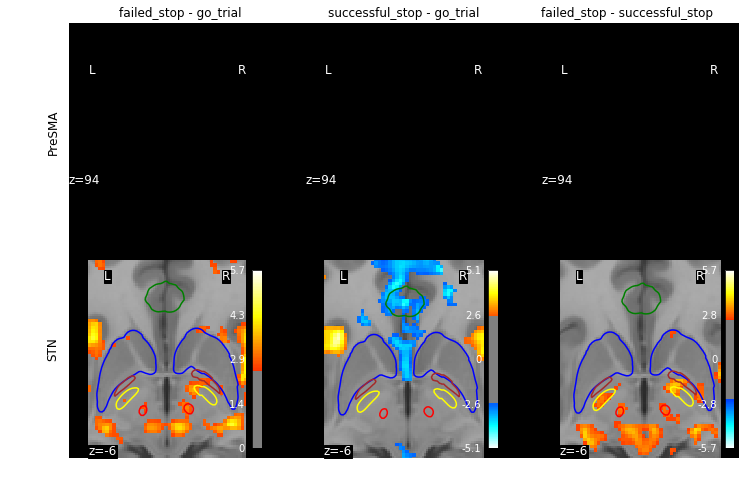

In [361]:
# f = plot_secondlevel_results(zmaps_se, roi_dict, 
#                              roi_to_plot=('PreSMA', 'STN'),
#                              bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz')
# f.subplots_adjust(hspace=0, wspace=0)

2. MultiEcho

In [22]:
# f = plot_secondlevel_results(zmaps_me, 
#                              roi_dict, 
#                              bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz')

### Smooth 5mm (deH et al)

In [23]:
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold

# SE
second_level_model_se_fwhm5 = SecondLevelModel(smoothing_fwhm=5)
second_level_model_se_fwhm5 = second_level_model_se_fwhm5.fit(first_level_models_se)
zmaps_se = {contrasts[0]: second_level_model_se_fwhm5.compute_contrast(first_level_contrast=contrasts[0]),
            contrasts[1]: second_level_model_se_fwhm5.compute_contrast(first_level_contrast=contrasts[1]),
            contrasts[2]: second_level_model_se_fwhm5.compute_contrast(first_level_contrast=contrasts[2])}
# FDR correction
thresholds_se = [
    map_threshold(zmaps_se[contrasts[0]], level=.05, height_control='fdr')[1],
    map_threshold(zmaps_se[contrasts[1]], level=.05, height_control='fdr')[1],
    map_threshold(zmaps_se[contrasts[2]], level=.05, height_control='fdr')[1]
]

# ME
second_level_model_me_fwhm5 = SecondLevelModel(smoothing_fwhm=3.2)
second_level_model_me_fwhm5 = second_level_model_me_fwhm5.fit(first_level_models_me)
zmaps_me = {contrasts[0]: second_level_model_me_fwhm5.compute_contrast(first_level_contrast=contrasts[0]),
            contrasts[1]: second_level_model_me_fwhm5.compute_contrast(first_level_contrast=contrasts[1]),
            contrasts[2]: second_level_model_me_fwhm5.compute_contrast(first_level_contrast=contrasts[2])}
# FDR correction
thresholds_me = [
    map_threshold(zmaps_me[contrasts[0]], level=.05, height_control='fdr')[1],
    map_threshold(zmaps_me[contrasts[1]], level=.05, height_control='fdr')[1],
    map_threshold(zmaps_me[contrasts[2]], level=.05, height_control='fdr')[1]
]


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: One contrast given, assuming it for all 3 runs
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [82]:
from scipy.stats import norm
p005_unc = norm.isf(0.005)

def plot_secondlevel_results2(zmaps, roi_map, bg_img=None, z_threshold=p005_unc, f=None, axes=None,
                              brain_mask='../Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                              roi_to_plot=('PreSMA', 'M1', 'ACC', 'rIFG', 'STR', 'GPe', 'GPi', 'STN'),
                              cut_coords=[None, None, None, None, None, None, None, None],
                              contrasts=('failed_stop - go_trial',
                                         'successful_stop - go_trial',
                                         'failed_stop - successful_stop'),
                              empty_plots=False, skip_all_but_last=False,
                              **kwargs):
    
    if f is None:
        gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1])
        f, axes = plt.subplots(len(roi_to_plot), len(zmaps)+3, gridspec_kw=gridspec)  # add 3 columns: 2 interspace, 1 on the right for the colorbar
 
    if empty_plots:
        f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
        return f, axes
    
    all_cut_coords = []
    all_disps = []
    for row_n, roi in enumerate(roi_to_plot):
        # for debugging
        if skip_all_but_last:
            if row_n < (len(roi_to_plot)-1):
                continue
        
        # get cut coordinates based on 1 hemisphere (if applicable)
        if roi in ['STR', 'STN', 'PreSMA', 'GPe', 'GPi']:
            roi_map = roi_dict[roi + '_L']
        else:
            roi_map = roi_dict[roi]
#        roi_map = make_conjunction_mask(roi_map['fn'], brain_mask)
        if roi == 'rIFG':
            ## saggital
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[0:1]
            else:
                this_cut_coords = cut_coords[row_n]
            display_mode='x'
            plot_rois = ['rIFG', 'M1', 'PreSMA_R']
        elif roi == 'STR':
            ## axial view
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[2:3]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='z'
            plot_rois = ['rIFG', 'M1',
                         'STR_L', 'GPe_L', 'GPi_L', 'STN_L',
                         'STR_R', 'GPe_R', 'GPi_R', 'STN_R']
        elif roi == 'STN':
            ## plot coronal view
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[1:2]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='y'
            plot_rois = ['rIFG', 'M1',
                         'STR_L', 'GPe_L', 'GPi_L', 'STN_L',
                         'STR_R', 'GPe_R', 'GPi_R', 'STN_R']

        all_cut_coords.append({display_mode: this_cut_coords[0]})
        
        # loop over contrasts for columns
        for col_n, zmap in enumerate(zmaps):
            if skip_all_but_last:
                if col_n < (len(zmaps)-1):
                    continue
            
            if row_n == (len(roi_to_plot)-1) and col_n == (len(zmaps)-1):
                # plot colobar in the last plot
                cbar = False
            else:
                cbar = False
            
            # do not plot in column 2 or 5
            plot_col = col_n
            if col_n > 1:
                plot_col = col_n + 1
            if col_n > 3:
                plot_col = col_n + 2
                
            if isinstance(z_threshold, list):
                this_threshold = z_threshold[col_n]
            else:
                this_threshold = z_threshold
            ax = axes[row_n, plot_col]
            
            print(cbar)
            disp = plotting.plot_stat_map(zmap, bg_img=bg_img, 
                                          threshold=this_threshold, cut_coords=this_cut_coords,
                                          display_mode=display_mode, axes=ax, colorbar=cbar, **kwargs)
        
            # just plot *all* contours, always
            for roi_ in plot_rois:
                roi_map = roi_dict[roi_]
#             for roi_, roi_map in roi_dict.items():
                add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

            # set new xlimits if necessary (ie zoom for STN view)
            if 'STN' in roi and display_mode == 'z':
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([.25, .75], cur_xlim)
                new_ylim = get_prop_limits([.40, .90], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
            elif 'STN' in roi and display_mode == 'y':
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([.25, .75], cur_xlim)
                new_ylim = get_prop_limits([.25, .75], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
            elif 'STR' in roi and display_mode == 'z':
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([0, 1], cur_xlim)
                new_ylim = get_prop_limits([.3, 1], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
                
            all_disps.append(disp)
    
    # add labels
#     for ax, nm in zip(axes[0], zmaps.keys()):
#         ax.set_title(nm)
    if not skip_all_but_last:
        for row_n, ax in enumerate(axes[:,0]):
            cc = all_cut_coords[row_n]
            disp_mode = [x for x in cc.keys()][0]
            coord = cc[disp_mode]
            ax.annotate('%s = %d' %(disp_mode, int(coord)), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 0, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points', rotation=90,
                        size=16, ha='right', va='center')

    f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
    
    return f, axes, all_disps

In [68]:
keys = [x for x in zmaps_se.keys()]
zmaps_combined = [zmaps_se[keys[0]], zmaps_me[keys[0]], 
                  zmaps_se[keys[1]], zmaps_me[keys[1]], 
                  zmaps_se[keys[2]], zmaps_me[keys[2]]]
thresholds_combined = [thresholds_se[0], thresholds_me[0],
                       thresholds_se[1], thresholds_me[1],
                       thresholds_se[2], thresholds_me[2]]

In [26]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# from matplotlib.mlab import bivariate_normal

# class MidpointNormalize(colors.Normalize):
#     def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
#         self.midpoint = midpoint
#         colors.Normalize.__init__(self, vmin, vmax, clip)

#     def __call__(self, value, clip=None):
#         # I'm ignoring masked values and all kinds of edge cases to make a
#         # simple example...
#         x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
#         return np.ma.masked_array(np.interp(value, x, y))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


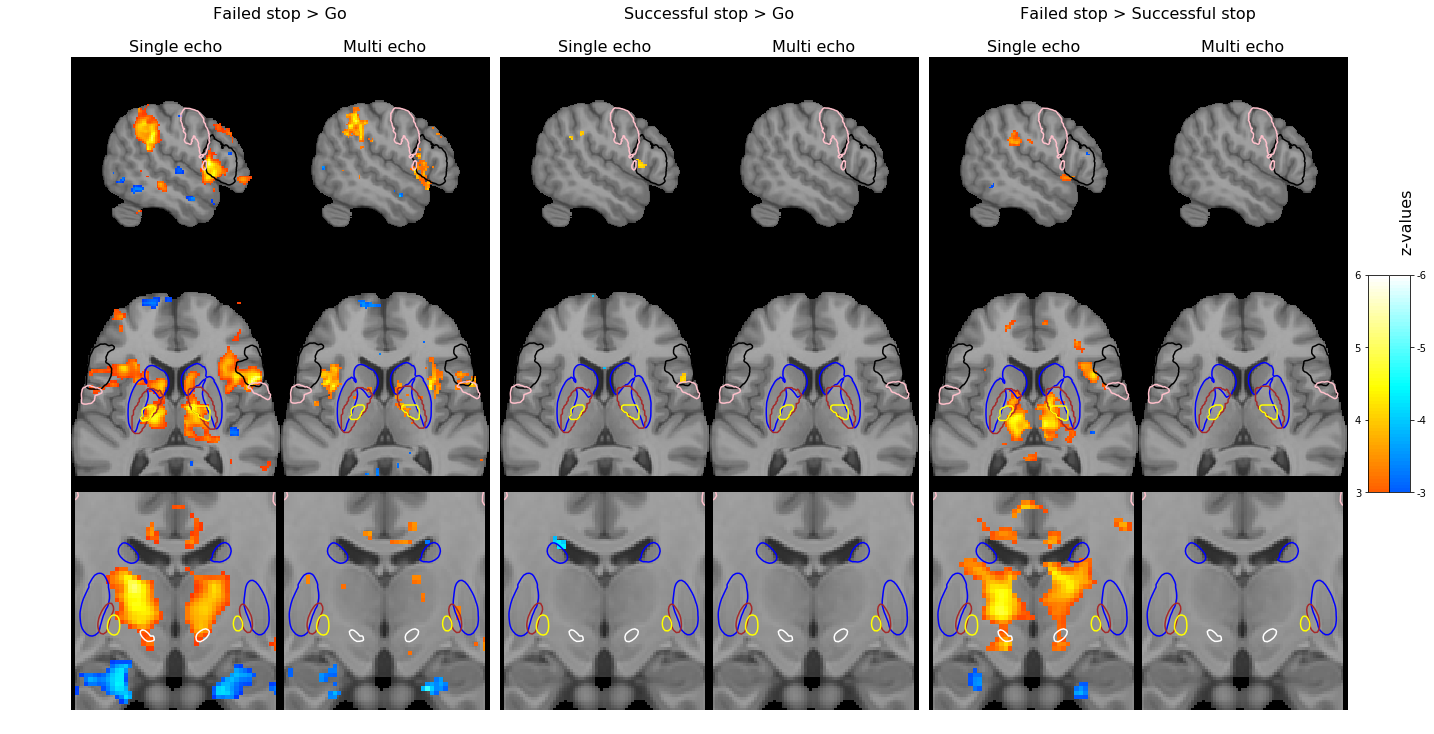

In [181]:
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_combined)+5, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_combined)+5, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_secondlevel_results2(zmaps_combined, roi_dict, z_threshold=thresholds_combined,
                                           f=f, axes=axes,
                                           roi_to_plot=['rIFG', 'STR', 'STN'],
                                           cut_coords=[[52], None, [-13]],
                                           bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                                           vmax=6, #colorbar=False, 
                                           annotate=False, empty_plots=False, 
                                           skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('Multi echo', size=16)
axes[0,3].set_title('Single echo', size=16)
axes[0,4].set_title('Multi echo', size=16)
axes[0,6].set_title('Single echo', size=16)
axes[0,7].set_title('Multi echo', size=16)

for row in range(axes.shape[0]):
    axes[row,2].set_visible(False)
    axes[row,5].set_visible(False)
    axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)
    
# for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(8):
    # save the axes bounding boxes for later use
    ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

# make nice
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )

width_mid = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
mid_center = inv.transform( (width_mid, 1) )

width_right = ext[6][0]+(ext[7][0]+ext[7][1]-ext[6][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0], .93, "Failed stop > Go", va="center", ha="center", size=16)
plt.figtext(mid_center[0], .93, "Successful stop > Go", va="center", ha="center", size=16)
plt.figtext(right_center[0], .93, "Failed stop > Successful stop", va="center", ha="center", size=16)

def _draw_colorbarSM2(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = plotting.cm.cold_hot
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format='%.2g')
    
    if flip:
        colorbar_ax.invert_yaxis()
        colorbar_ax.yaxis.tick_right()
    else:
        colorbar_ax.yaxis.tick_left()

#     tick_color = 'w'
#     for tick in colorbar_ax.yaxis.get_ticklabels():
#         tick.set_color(tick_color)
#     colorbar_ax.yaxis.set_tick_params(width=0)
    return colorbar_ax

# colorbar
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax2 = f.add_subplot(gs[1,-1])

cbar_ax1 = _draw_colorbarSM2(colorbar_ax=cbar_ax1, truncation_limits=(3,6), offset=thresholds_combined[0], flip=False)
cbar_ax2 = _draw_colorbarSM2(colorbar_ax=cbar_ax2, truncation_limits=(-3,-6), offset=thresholds_combined[0], flip=True)
cbar_ax2.set_title('z-values', rotation=90, fontsize=16, ha='left', pad=75)

f.savefig('./glm.pdf')#, bbox_inches='tight')

In [163]:
# def _draw_colorbarSM2(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True):
#     from matplotlib.colorbar import ColorbarBase
#     from matplotlib import colors
#     our_cmap = plotting.cm.cold_hot
#     if flip:
#         truncation_limits = [truncation_limits[1], truncation_limits[0]]
#     ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
#     bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
#     norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    
#     # some colormap hacking
#     cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
#     istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
#     istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
#     for i in range(istart, istop):
#         cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
#     our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

#     ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
#                  orientation='vertical', cmap=our_cmap, boundaries=bounds,
#                  spacing='proportional', format='%.2g')
    
#     if flip:
#         colorbar_ax.invert_yaxis()
#         colorbar_ax.yaxis.tick_right()
#     else:
#         colorbar_ax.yaxis.tick_left()

# #     tick_color = 'w'
# #     for tick in colorbar_ax.yaxis.get_ticklabels():
# #         tick.set_color(tick_color)
# #     colorbar_ax.yaxis.set_tick_params(width=0)
#     return colorbar_ax

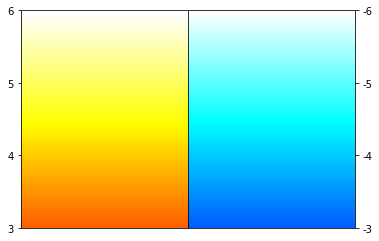

In [164]:
# tmp_f, tmp_ax = plt.subplots(1, 2, gridspec_kw={'wspace': 0})
# ax_tmp = _draw_colorbarSM2(colorbar_ax=tmp_ax[0], truncation_limits=(3,6), offset=thresholds_combined[0], flip=False)
# ax_tmp = _draw_colorbarSM2(colorbar_ax=tmp_ax[1], truncation_limits=(-3,-6), offset=thresholds_combined[0], flip=True)
# tmp_f.show()

In [ ]:
ax_tmp.set_ylim

In [ ]:
f.gri

In [489]:
len(zmaps_combined)*4, 12

(24, 12)

In [482]:
disps[-1].__dict__

{'cut_coords': [-6.464108817452171],
 'frame_axes': <matplotlib.axes._subplots.AxesSubplot at 0x7eea3f7f8eb8>,
 'rect': (0.7729508196721311,
  0.1250000000000001,
  0.8999999999999999,
  0.3766666666666667),
 '_black_bg': True,
 '_brain_color': (0.5, 0.5, 0.5),
 '_colorbar': True,
 '_colorbar_width': 0.006352459016393442,
 '_colorbar_margin': {'left': 0.03176229508196721,
  'right': 0.0025409836065573765,
  'top': 0.01258333333333333,
  'bottom': 0.01258333333333333},
 'axes': {-6.464108817452171: <nilearn.plotting.displays.CutAxes at 0x7eea3edcc7f0>}}

[52]
x
[8.030823192873697]
z
[-6.464108817452171]
z


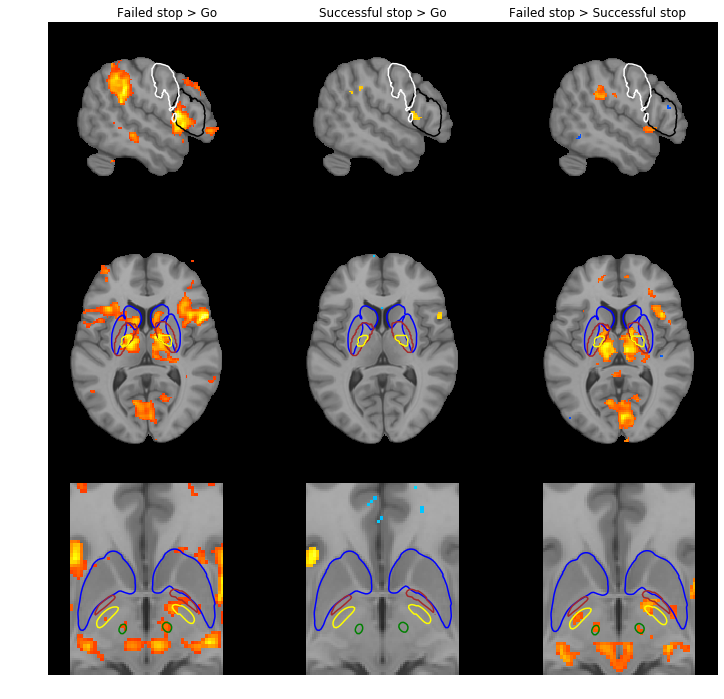

In [457]:
f, axes = plot_secondlevel_results(zmaps_se, roi_dict, z_threshold=thresholds_se,
                                   roi_to_plot=['rIFG', 'STR', 'STN'],
                                   cut_coords=[[52], None, None],
                                   bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                                   vmax=6, colorbar=False, annotate=False)
axes[0,0].set_title('Failed stop > Go')
axes[0,1].set_title('Successful stop > Go')
axes[0,2].set_title('Failed stop > Successful stop')
f.subplots_adjust(hspace=-.1, wspace=-.1)

In [ ]:
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


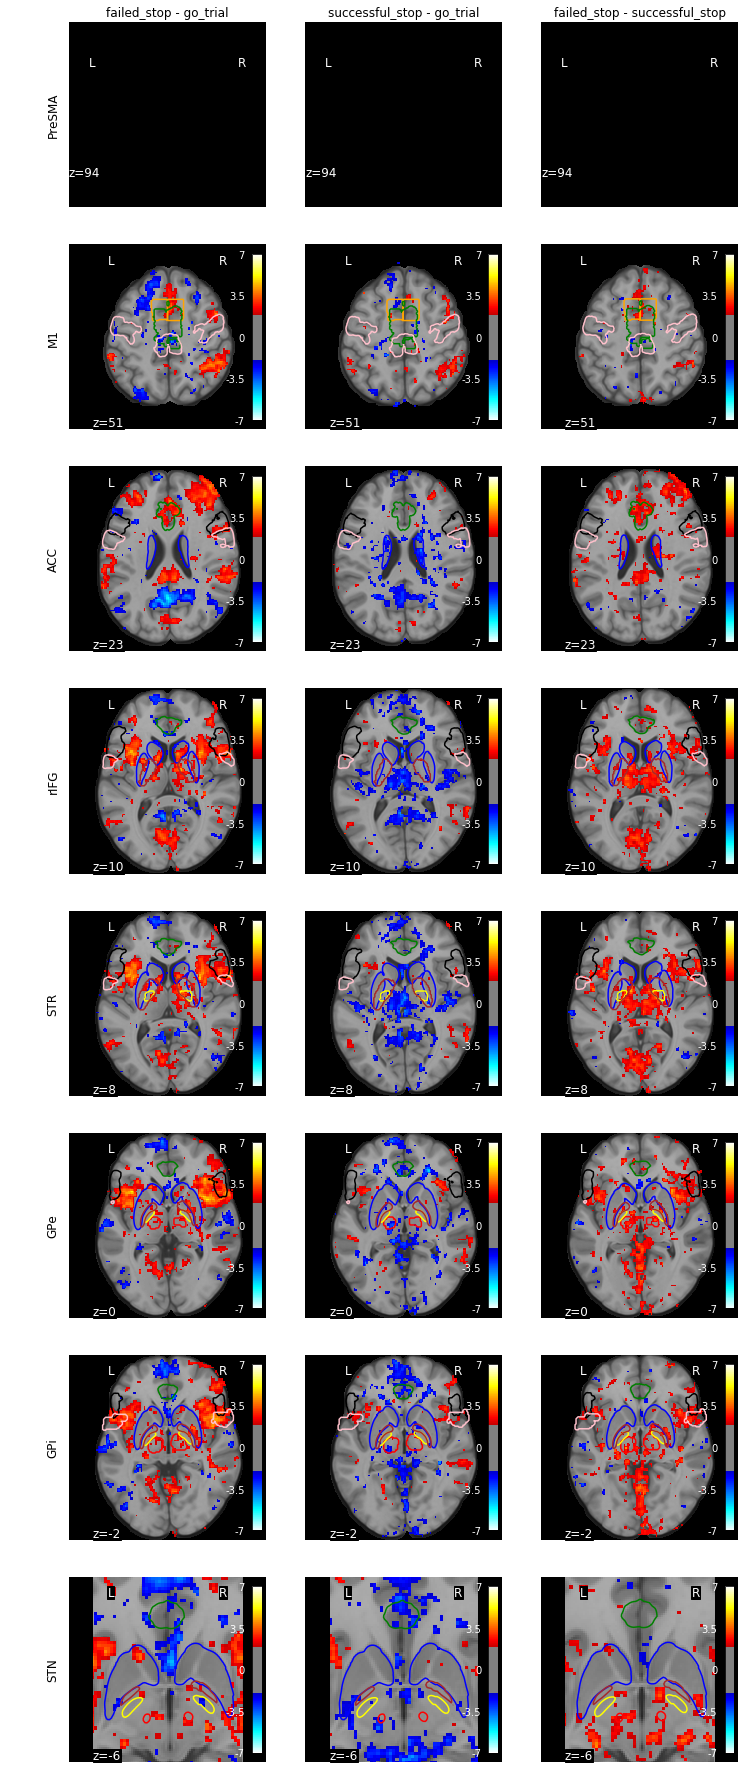

In [309]:
f = plot_secondlevel_results(zmaps_me, roi_dict, z_threshold=2,
                             bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain.nii.gz',
                             vmax=7)

In [ ]:
plotting.plot_stat_map(zmaps_me['failed_stop - go_trial'], 
                       bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz',
                       threshold=2.58)

In [ ]:
plotting.plot_stat_map(zmaps_se['failed_stop - go_trial'], 
                       bg_img='/home/stevenm/Templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz',
                       threshold=2.58)